# Sentiment Analysis

In [1]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

    100% |████████████████████████████████| 24.2MB 2.0MB/s eta 0:00:01
    100% |████████████████████████████████| 122kB 30.2MB/s ta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/25/6c/db/7dcb26f19fb260c5629af85ed1c8ef9641143444fc7ec1fa08
Successfully built smart-open
  Found existing installation: smart-open 1.7.1
    Uninstalling smart-open-1.7.1:
      Successfully uninstalled smart-open-1.7.1
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |███

In [4]:
!pip install --ignore-installed --upgrade tensorflow==1.6.0
!pip install keras==2.1.5

    100% |████████████████████████████████| 45.9MB 1.1MB/s eta 0:00:01
    100% |████████████████████████████████| 19.7MB 2.4MB/s eta 0:00:01
    100% |████████████████████████████████| 1.3MB 19.7MB/s ta 0:00:01
    100% |████████████████████████████████| 13.5MB 3.9MB/s eta 0:00:01
    100% |████████████████████████████████| 3.1MB 13.5MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 5.3MB/s ta 0:00:01
    100% |████████████████████████████████| 798kB 23.6MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 27.0MB/s ta 0:00:01
    100% |████████████████████████████████| 307kB 28.8MB/s ta 0:00:01
    100% |████████████████████████████████| 890kB 23.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for grpcio ... done
  Stored in directory: /root/.cache/pip/wheels/1e/e9/13/2ce6c99171a977bad2f9a4bccfa596a6e7ea060b9fbff51bc3
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aa

You are using pip version 18.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer



import tensorflow as tf
import keras


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [12]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

image_paths = []
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/allfiles/names.pkl
/kaggle/input/allfiles/texts.pkl


In [48]:
dataset_filename = os.listdir("/kaggle/input")[0]
dataset_path = os.path.join("..","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: ../input/finalone


In [49]:
df.shape

(1600000, 6)

In [56]:
with open('/kaggle/input/allfiles/texts.pkl', 'rb') as f:
    texts = pickle.load(f)

In [57]:
with open('/kaggle/input/allfiles/names.pkl', 'rb') as f:
    ids = pickle.load(f)

In [64]:
data = {'id':ids, 'text':texts}

main = pd.DataFrame (data, columns = ['id','text'])


main = pd.DataFrame()
main

In [9]:
print("Dataset size:", len(df))

Dataset size: 1600000


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [68]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [69]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 1.02 s, sys: 4.04 ms, total: 1.03 s
Wall time: 1.03 s


Text(0.5,1,'Dataset labels distribuition')

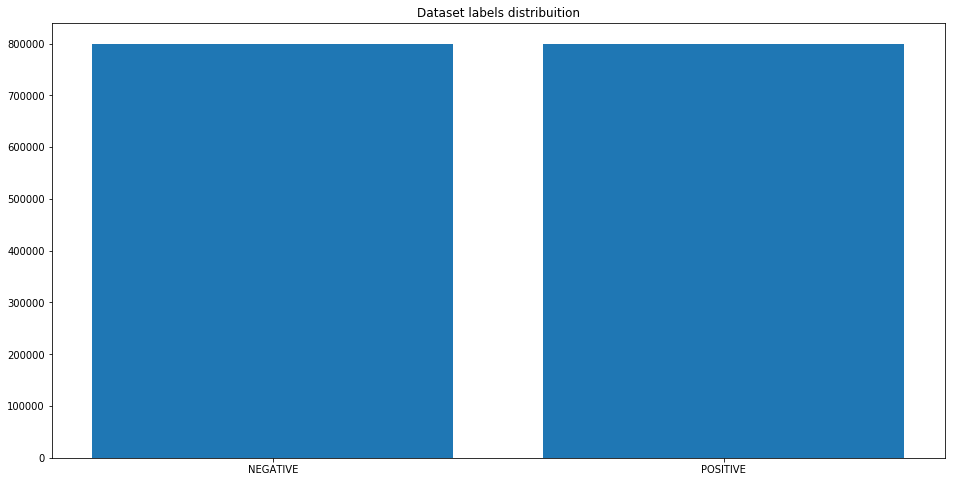

In [70]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [71]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [74]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [75]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))



CPU times: user 1min 8s, sys: 161 ms, total: 1min 9s
Wall time: 1min 9s


In [77]:
main.text =  main.text.apply(lambda x:preprocess(x))

### Split train and test

In [78]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [79]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.68 s, sys: 364 ms, total: 4.05 s
Wall time: 4.15 s


In [81]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [82]:
w2v_model.build_vocab(documents)

2020-07-20 18:11:38,906 : INFO : collecting all words and their counts
2020-07-20 18:11:38,908 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-20 18:11:38,938 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-07-20 18:11:38,965 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-07-20 18:11:38,991 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-07-20 18:11:39,020 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-07-20 18:11:39,048 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-07-20 18:11:39,077 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-07-20 18:11:39,106 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-07-20 18:11:39,135 : INFO : PROGRESS: at s

2020-07-20 18:11:41,015 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-07-20 18:11:41,045 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-07-20 18:11:41,074 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-07-20 18:11:41,105 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-07-20 18:11:41,135 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-07-20 18:11:41,164 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-07-20 18:11:41,195 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-07-20 18:11:41,226 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-07-20 18:11:41,256 : INFO : PROGRESS: at sentence #800000, processed 577088

In [83]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [84]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-07-20 18:11:43,803 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-20 18:11:44,912 : INFO : EPOCH 1 - PROGRESS: at 3.14% examples, 236028 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:11:45,922 : INFO : EPOCH 1 - PROGRESS: at 6.40% examples, 249717 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:11:46,955 : INFO : EPOCH 1 - PROGRESS: at 9.45% examples, 247069 words/s, in_qsize 11, out_qsize 2
2020-07-20 18:11:47,976 : INFO : EPOCH 1 - PROGRESS: at 12.82% examples, 252798 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:11:48,976 : INFO : EPOCH 1 - PROGRESS: at 15.51% examples, 246885 words/s, in_qsize 15, out_qsize 1
2020-07-20 18:11:50,034 : INFO : EPOCH 1 - PROGRESS: at 19.84% examples, 262748 words/s, in_qsize 14, out_qsize 3
2020-07-20 18:11:51,126 : INFO : EPOCH 1 - PROGRESS: at 23.20% examples, 260773 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:11:52,172 : INFO : EPOCH 1 - PROGRESS: at

2020-07-20 18:12:44,055 : INFO : EPOCH 3 - PROGRESS: at 22.87% examples, 294024 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:12:45,061 : INFO : EPOCH 3 - PROGRESS: at 27.42% examples, 304583 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:12:46,088 : INFO : EPOCH 3 - PROGRESS: at 31.43% examples, 306590 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:12:47,136 : INFO : EPOCH 3 - PROGRESS: at 35.54% examples, 308362 words/s, in_qsize 14, out_qsize 2
2020-07-20 18:12:48,154 : INFO : EPOCH 3 - PROGRESS: at 38.46% examples, 301331 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:12:49,166 : INFO : EPOCH 3 - PROGRESS: at 41.70% examples, 298085 words/s, in_qsize 13, out_qsize 1
2020-07-20 18:12:50,190 : INFO : EPOCH 3 - PROGRESS: at 45.37% examples, 297893 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:12:51,229 : INFO : EPOCH 3 - PROGRESS: at 49.16% examples, 298046 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:12:52,281 : INFO : EPOCH 3 - PROGRESS: at 52.73% examples, 296735 words/s,

2020-07-20 18:13:45,059 : INFO : EPOCH 5 - PROGRESS: at 51.21% examples, 309480 words/s, in_qsize 15, out_qsize 2
2020-07-20 18:13:46,111 : INFO : EPOCH 5 - PROGRESS: at 55.64% examples, 311572 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:13:47,152 : INFO : EPOCH 5 - PROGRESS: at 59.23% examples, 309644 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:13:48,278 : INFO : EPOCH 5 - PROGRESS: at 61.71% examples, 301110 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:13:49,327 : INFO : EPOCH 5 - PROGRESS: at 64.73% examples, 297401 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:13:50,446 : INFO : EPOCH 5 - PROGRESS: at 68.21% examples, 294890 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:13:51,479 : INFO : EPOCH 5 - PROGRESS: at 72.21% examples, 296133 words/s, in_qsize 15, out_qsize 2
2020-07-20 18:13:52,487 : INFO : EPOCH 5 - PROGRESS: at 75.78% examples, 295902 words/s, in_qsize 14, out_qsize 0
2020-07-20 18:13:53,610 : INFO : EPOCH 5 - PROGRESS: at 78.84% examples, 292161 words/s,

2020-07-20 18:14:45,313 : INFO : EPOCH 7 - PROGRESS: at 71.46% examples, 297922 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:14:46,350 : INFO : EPOCH 7 - PROGRESS: at 75.79% examples, 300186 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:14:47,456 : INFO : EPOCH 7 - PROGRESS: at 80.03% examples, 300891 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:14:48,513 : INFO : EPOCH 7 - PROGRESS: at 82.53% examples, 295951 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:14:49,670 : INFO : EPOCH 7 - PROGRESS: at 85.88% examples, 293192 words/s, in_qsize 16, out_qsize 2
2020-07-20 18:14:50,723 : INFO : EPOCH 7 - PROGRESS: at 88.91% examples, 290840 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:14:51,750 : INFO : EPOCH 7 - PROGRESS: at 92.94% examples, 292001 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:14:52,760 : INFO : EPOCH 7 - PROGRESS: at 96.42% examples, 291638 words/s, in_qsize 13, out_qsize 1
2020-07-20 18:14:53,649 : INFO : worker thread finished; awaiting finish of 7 more threa

2020-07-20 18:15:46,264 : INFO : EPOCH 9 - PROGRESS: at 95.01% examples, 306916 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:15:47,206 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-20 18:15:47,221 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-20 18:15:47,223 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-20 18:15:47,230 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-20 18:15:47,275 : INFO : EPOCH 9 - PROGRESS: at 99.67% examples, 309710 words/s, in_qsize 3, out_qsize 1
2020-07-20 18:15:47,280 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-20 18:15:47,291 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-20 18:15:47,298 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-20 18:15:47,306 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-20 18:15:47,307 : INFO : EPOCH - 9 : 

2020-07-20 18:16:41,664 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-20 18:16:41,675 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-20 18:16:41,686 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-20 18:16:41,688 : INFO : EPOCH - 11 : training on 9227204 raw words (8223592 effective words) took 25.8s, 319076 effective words/s
2020-07-20 18:16:42,782 : INFO : EPOCH 12 - PROGRESS: at 2.93% examples, 223789 words/s, in_qsize 9, out_qsize 0
2020-07-20 18:16:43,818 : INFO : EPOCH 12 - PROGRESS: at 6.08% examples, 236395 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:16:44,835 : INFO : EPOCH 12 - PROGRESS: at 9.45% examples, 247939 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:16:45,842 : INFO : EPOCH 12 - PROGRESS: at 13.14% examples, 260753 words/s, in_qsize 14, out_qsize 0
2020-07-20 18:16:46,917 : INFO : EPOCH 12 - PROGRESS: at 17.02% examples, 268469 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:16:

2020-07-20 18:17:38,342 : INFO : EPOCH 14 - PROGRESS: at 6.40% examples, 251556 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:17:39,361 : INFO : EPOCH 14 - PROGRESS: at 9.55% examples, 252315 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:17:40,474 : INFO : EPOCH 14 - PROGRESS: at 13.68% examples, 265948 words/s, in_qsize 15, out_qsize 2
2020-07-20 18:17:41,483 : INFO : EPOCH 14 - PROGRESS: at 18.00% examples, 282683 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:17:42,484 : INFO : EPOCH 14 - PROGRESS: at 21.90% examples, 288758 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:17:43,532 : INFO : EPOCH 14 - PROGRESS: at 25.91% examples, 292457 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:17:44,540 : INFO : EPOCH 14 - PROGRESS: at 29.92% examples, 296683 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:17:45,592 : INFO : EPOCH 14 - PROGRESS: at 34.03% examples, 299507 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:17:46,594 : INFO : EPOCH 14 - PROGRESS: at 38.14% examples, 303214 w

2020-07-20 18:18:37,937 : INFO : EPOCH 16 - PROGRESS: at 26.23% examples, 298276 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:18:38,973 : INFO : EPOCH 16 - PROGRESS: at 30.78% examples, 306194 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:18:40,008 : INFO : EPOCH 16 - PROGRESS: at 34.78% examples, 307511 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:18:41,022 : INFO : EPOCH 16 - PROGRESS: at 39.00% examples, 310983 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:18:42,061 : INFO : EPOCH 16 - PROGRESS: at 43.10% examples, 312342 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:18:43,105 : INFO : EPOCH 16 - PROGRESS: at 47.21% examples, 313329 words/s, in_qsize 13, out_qsize 0
2020-07-20 18:18:44,109 : INFO : EPOCH 16 - PROGRESS: at 50.45% examples, 309810 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:18:45,186 : INFO : EPOCH 16 - PROGRESS: at 53.92% examples, 306479 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:18:46,189 : INFO : EPOCH 16 - PROGRESS: at 57.16% examples, 303895

2020-07-20 18:19:38,308 : INFO : EPOCH 18 - PROGRESS: at 51.75% examples, 315445 words/s, in_qsize 10, out_qsize 2
2020-07-20 18:19:39,376 : INFO : EPOCH 18 - PROGRESS: at 55.32% examples, 312528 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:19:40,596 : INFO : EPOCH 18 - PROGRESS: at 58.58% examples, 305315 words/s, in_qsize 11, out_qsize 6
2020-07-20 18:19:41,679 : INFO : EPOCH 18 - PROGRESS: at 63.00% examples, 307371 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:19:42,684 : INFO : EPOCH 18 - PROGRESS: at 67.45% examples, 310500 words/s, in_qsize 14, out_qsize 0
2020-07-20 18:19:43,769 : INFO : EPOCH 18 - PROGRESS: at 71.56% examples, 310588 words/s, in_qsize 14, out_qsize 2
2020-07-20 18:19:44,793 : INFO : EPOCH 18 - PROGRESS: at 76.11% examples, 313396 words/s, in_qsize 16, out_qsize 1
2020-07-20 18:19:45,799 : INFO : EPOCH 18 - PROGRESS: at 79.81% examples, 312786 words/s, in_qsize 13, out_qsize 5
2020-07-20 18:19:46,842 : INFO : EPOCH 18 - PROGRESS: at 84.26% examples, 314574

2020-07-20 18:20:39,291 : INFO : EPOCH 20 - PROGRESS: at 76.00% examples, 302753 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:20:40,319 : INFO : EPOCH 20 - PROGRESS: at 80.03% examples, 303600 words/s, in_qsize 15, out_qsize 1
2020-07-20 18:20:41,333 : INFO : EPOCH 20 - PROGRESS: at 84.26% examples, 305348 words/s, in_qsize 13, out_qsize 2
2020-07-20 18:20:42,375 : INFO : EPOCH 20 - PROGRESS: at 88.59% examples, 306935 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:20:43,402 : INFO : EPOCH 20 - PROGRESS: at 92.83% examples, 308474 words/s, in_qsize 12, out_qsize 2
2020-07-20 18:20:44,498 : INFO : EPOCH 20 - PROGRESS: at 96.96% examples, 308242 words/s, in_qsize 13, out_qsize 0
2020-07-20 18:20:45,174 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-20 18:20:45,179 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-20 18:20:45,228 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-20 18:20:45,234 : INFO : work

2020-07-20 18:21:39,065 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-20 18:21:39,082 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-20 18:21:39,121 : INFO : worker thread finished; awaiting finish of 4 more threads
2020-07-20 18:21:39,123 : INFO : worker thread finished; awaiting finish of 3 more threads
2020-07-20 18:21:39,125 : INFO : EPOCH 22 - PROGRESS: at 99.78% examples, 315123 words/s, in_qsize 2, out_qsize 1
2020-07-20 18:21:39,126 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-07-20 18:21:39,137 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-07-20 18:21:39,144 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-07-20 18:21:39,145 : INFO : EPOCH - 22 : training on 9227204 raw words (8222754 effective words) took 26.1s, 315562 effective words/s
2020-07-20 18:21:40,251 : INFO : EPOCH 23 - PROGRESS: at 3.14% examples, 242194 words/s, in_qsize 15, out_qsiz

2020-07-20 18:22:32,973 : INFO : EPOCH - 24 : training on 9227204 raw words (8222187 effective words) took 25.8s, 318107 effective words/s
2020-07-20 18:22:33,984 : INFO : EPOCH 25 - PROGRESS: at 3.36% examples, 276124 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:22:35,010 : INFO : EPOCH 25 - PROGRESS: at 6.84% examples, 276877 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:22:36,036 : INFO : EPOCH 25 - PROGRESS: at 10.31% examples, 277308 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:22:37,166 : INFO : EPOCH 25 - PROGRESS: at 13.79% examples, 271587 words/s, in_qsize 15, out_qsize 2
2020-07-20 18:22:38,173 : INFO : EPOCH 25 - PROGRESS: at 18.32% examples, 290007 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:22:39,208 : INFO : EPOCH 25 - PROGRESS: at 22.22% examples, 293297 words/s, in_qsize 11, out_qsize 4
2020-07-20 18:22:40,272 : INFO : EPOCH 25 - PROGRESS: at 26.67% examples, 300619 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:22:41,283 : INFO : EPOCH 25 - PROGRESS: at 3

2020-07-20 18:23:33,950 : INFO : EPOCH 27 - PROGRESS: at 26.56% examples, 299199 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:23:35,002 : INFO : EPOCH 27 - PROGRESS: at 30.13% examples, 296725 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:23:36,006 : INFO : EPOCH 27 - PROGRESS: at 33.81% examples, 297273 words/s, in_qsize 15, out_qsize 1
2020-07-20 18:23:37,007 : INFO : EPOCH 27 - PROGRESS: at 37.70% examples, 299491 words/s, in_qsize 14, out_qsize 3
2020-07-20 18:23:38,046 : INFO : EPOCH 27 - PROGRESS: at 42.02% examples, 303466 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:23:39,151 : INFO : EPOCH 27 - PROGRESS: at 46.13% examples, 304105 words/s, in_qsize 15, out_qsize 3
2020-07-20 18:23:40,197 : INFO : EPOCH 27 - PROGRESS: at 50.45% examples, 306583 words/s, in_qsize 14, out_qsize 2
2020-07-20 18:23:41,206 : INFO : EPOCH 27 - PROGRESS: at 54.03% examples, 305551 words/s, in_qsize 13, out_qsize 0
2020-07-20 18:23:42,243 : INFO : EPOCH 27 - PROGRESS: at 56.95% examples, 300662

2020-07-20 18:24:33,901 : INFO : EPOCH 29 - PROGRESS: at 52.62% examples, 320884 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:24:34,973 : INFO : EPOCH 29 - PROGRESS: at 57.38% examples, 324196 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:24:36,064 : INFO : EPOCH 29 - PROGRESS: at 60.96% examples, 320396 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:24:37,151 : INFO : EPOCH 29 - PROGRESS: at 64.62% examples, 317651 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:24:38,174 : INFO : EPOCH 29 - PROGRESS: at 67.34% examples, 311898 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:24:39,176 : INFO : EPOCH 29 - PROGRESS: at 71.56% examples, 313756 words/s, in_qsize 13, out_qsize 1
2020-07-20 18:24:40,182 : INFO : EPOCH 29 - PROGRESS: at 75.14% examples, 312647 words/s, in_qsize 15, out_qsize 1
2020-07-20 18:24:41,186 : INFO : EPOCH 29 - PROGRESS: at 79.71% examples, 315541 words/s, in_qsize 16, out_qsize 0
2020-07-20 18:24:42,274 : INFO : EPOCH 29 - PROGRESS: at 84.04% examples, 316131

2020-07-20 18:25:33,819 : INFO : EPOCH 31 - PROGRESS: at 75.24% examples, 314680 words/s, in_qsize 10, out_qsize 0
2020-07-20 18:25:34,823 : INFO : EPOCH 31 - PROGRESS: at 79.38% examples, 315759 words/s, in_qsize 14, out_qsize 0
2020-07-20 18:25:35,836 : INFO : EPOCH 31 - PROGRESS: at 83.62% examples, 317036 words/s, in_qsize 14, out_qsize 0
2020-07-20 18:25:36,843 : INFO : EPOCH 31 - PROGRESS: at 87.61% examples, 317489 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:25:37,882 : INFO : EPOCH 31 - PROGRESS: at 91.85% examples, 318202 words/s, in_qsize 15, out_qsize 0
2020-07-20 18:25:38,891 : INFO : EPOCH 31 - PROGRESS: at 96.21% examples, 319627 words/s, in_qsize 14, out_qsize 1
2020-07-20 18:25:39,679 : INFO : worker thread finished; awaiting finish of 7 more threads
2020-07-20 18:25:39,697 : INFO : worker thread finished; awaiting finish of 6 more threads
2020-07-20 18:25:39,710 : INFO : worker thread finished; awaiting finish of 5 more threads
2020-07-20 18:25:39,711 : INFO : work

CPU times: user 25min 4s, sys: 8.8 s, total: 25min 13s
Wall time: 14min 23s


(263123719, 295270528)

In [85]:
w2v_model.most_similar("love")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-07-20 18:26:07,398 : INFO : precomputing L2-norms of word weight vectors
/opt/conda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('luv', 0.5786606669425964),
 ('loves', 0.5568316578865051),
 ('loved', 0.5540191531181335),
 ('adore', 0.5240697860717773),
 ('amazing', 0.510637104511261),
 ('looove', 0.49301809072494507),
 ('lovee', 0.4603871703147888),
 ('awesome', 0.45846691727638245),
 ('loveee', 0.45386624336242676),
 ('loooove', 0.4489929676055908)]

### Tokenize Text

In [86]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 30.2 s, sys: 173 ms, total: 30.4 s
Wall time: 30.4 s


In [87]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 48.4 s, sys: 1.03 s, total: 49.4 s
Wall time: 50 s


In [88]:
x_main = pad_sequences(tokenizer.texts_to_sequences(main.text), maxlen=SEQUENCE_LENGTH)

### Label Encoder 

In [89]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [90]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [91]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [92]:
print(x_main.shape)

(239, 300)


In [93]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [94]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [95]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [96]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


### Compile model

In [97]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [98]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [99]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 692s 600us/step - loss: 0.5048 - acc: 0.7502 - val_loss: 0.4651 - val_acc: 0.7786
Epoch 2/8
1152000/1152000 [==============================] - 701s 609us/step - loss: 0.4802 - acc: 0.7666 - val_loss: 0.4589 - val_acc: 0.7826
Epoch 3/8
1152000/1152000 [==============================] - 694s 603us/step - loss: 0.4744 - acc: 0.7706 - val_loss: 0.4541 - val_acc: 0.7848
Epoch 4/8
1152000/1152000 [==============================] - 690s 599us/step - loss: 0.4705 - acc: 0.7726 - val_loss: 0.4521 - val_acc: 0.7864
Epoch 5/8
1152000/1152000 [==============================] - 683s 593us/step - loss: 0.4675 - acc: 0.7750 - val_loss: 0.4509 - val_acc: 0.7879
Epoch 6/8
1152000/1152000 [==============================] - 653s 567us/step - loss: 0.4656 - acc: 0.7759 - val_loss: 0.4495 - val_acc: 0.7884
Epoch 7/8
1152000/1152000 [==============================] - 645s 560us/step - loss: 0.46

### Evaluate

In [100]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 67s 209us/step

ACCURACY: 0.789121875
LOSS: 0.44831198053359983
CPU times: user 1min 30s, sys: 7.23 s, total: 1min 37s
Wall time: 1min 6s


### Predict

In [116]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'Random'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'Negative'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'Positive'

        return label
    else:
        return 'Negative' if score < 0.5 else 'Positive'

In [124]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [125]:
predict("LGBT")

{'label': 'Random',
 'score': 0.5537341237068176,
 'elapsed_time': 0.18327713012695312}

In [128]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return label

In [145]:
SENTIMENT_THRESHOLDS = (0.49, 0.65)


In [146]:
response = []

for t in texts:
    response.append(predict(t))
response

['Positive',
 'Positive',
 'Positive',
 'Positive',
 'Random',
 'Random',
 'Positive',
 'Random',
 'Positive',
 'Negative',
 'Positive',
 'Random',
 'Random',
 'Positive',
 'Random',
 'Negative',
 'Positive',
 'Random',
 'Random',
 'Random',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Random',
 'Positive',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Negative',
 'Negative',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Positive',
 'Random',
 'Random',
 'Random',
 'Negative',
 'Random',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Random',
 'Random',
 'Positive',
 'Negative',
 'Negative',
 'Random',
 'Positive',
 'Random',
 'Random',
 'Positive',
 'Negative',
 'Negative',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Negative',
 'Positive',
 'Positive',
 'Random',
 'Positive',
 'Random',
 'Negative',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Random',
 'Pos

In [147]:
with open('result.pkl', 'wb') as f:
    pickle.dump(response, f)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)